In [1]:
import networkx as nx
#import pylab as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from timeit import default_timer as timer
from matplotlib.pyplot import figure
import statistics


In [2]:
PR_df = pd.read_csv('./PR_df.csv')
PR_df.sort_values(by='0',inplace = True, ascending=False)
PR_df.reset_index(drop = True, inplace = True)
PR_df.rename(columns={'Unnamed: 0':'Author', '0':'PR_values'}, inplace = True)
PR_df.head(20)

,Author,PR_values
0,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.042414
1,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.015953
2,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.014931
3,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.014887
4,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.014411
5,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.012219
6,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.010959
7,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.010631
8,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.010314
9,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.009873


In [3]:
DB_AA_originale = pd.read_csv('./DB_articles_authors_built.csv')


#genesis_tx_node_id = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']=='Not_available']['ToNodeId'].values[0]
#RIMUOVO LE CITAZIONI INIZIALI FATTE VERSO LA GENESIS TX DAGLI ARTICOLI DI FRONTIERA
#DB_AA_originale = DB_AA_originale[DB_AA_originale['ToNodeId']!= genesis_tx_node_id]
DB_AA_originale.head()

,FromNodeId,From_Author_Pub_Key,ToNodeId,To_Author_Pub_key
0,6fa885a34dedefccbe0dfa66a25bea75f8582c16961bc8...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,9eeac919ecf6143c012aea787e2941e15e61919722d761...,Not_available
1,a41f0364419573ad34dcb7fa3a430377289da6c611332b...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,9eeac919ecf6143c012aea787e2941e15e61919722d761...,Not_available
2,d7c46633d0e08d81d0140b8b2e21eaf04e4ff0a646ed54...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,9eeac919ecf6143c012aea787e2941e15e61919722d761...,Not_available
3,f6875f955a15bea705608ddf89a11e4dec6adee164d9e8...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,a41f0364419573ad34dcb7fa3a430377289da6c611332b...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
4,ee468adc9cfa812d0cf7530ec5a69d2ed61fc7adeaa456...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,9eeac919ecf6143c012aea787e2941e15e61919722d761...,Not_available


In [4]:
DB_AA_originale.FromNodeId.nunique()

1066

In [5]:
DB_AA_originale.From_Author_Pub_Key.nunique()

878

In [6]:
#load the msg_DB from file 
def readMsgDB():
    print('Checking for local message_id stored...\n')
    try: 
        file = open("lista_msgDB.txt", "r")
        msg_DB = file.readlines()

        for i in range(len(msg_DB)):
            msg_DB[i] = msg_DB[i].replace("\n", "")

        print(f'Found #{len(msg_DB)} messages from the file lista_msgDB.txt \n')

        file.close() 
    except:
        
        msg_DB = []

    
    return msg_DB

msg_DB = readMsgDB()

Checking for local message_id stored...

Found #1066 messages from the file lista_msgDB.txt 



In [9]:
#load the DF containing the communities found
Communities = pd.read_csv('./Best_Clusters_DF.csv')
Communities.sort_values(by='cluster_size',inplace = True)

Communities.reset_index(drop = True, inplace = True)

def replaceSlash(row):
    return row.replace('\\n','\n')

repS = np.vectorize(replaceSlash)

Communities.cluster_authors = repS(Communities.cluster_authors)

#Communities.head(0.1-1)

In [10]:
Communities.cluster_size.sum()

878

In [11]:
Communities[Communities['cluster_size']==1]

,cluster_authors,cluster_size
0,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1
1,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1
2,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1
3,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1
4,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1
5,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1
6,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1


In [10]:
#Communities.index.values

In [12]:
#Costruisco grafo avente tanti nodi quante communities. Ogni arco a->b esiste <=> la community a contiene un 
#autore che cita un autore contenuto nella community b

num_nodi = len(Communities)


#GRAPH CREATION


#STAMPA GRAFO
D=nx.DiGraph()

for i in Communities.index.values:
    D.add_node(str(i),nodeId = str(i))
    
for i in Communities.index.values: 
    
    inner_authors = Communities.iloc[i]['cluster_authors'].split("*")
    
    for j in Communities.index.values:
        
        if(i!=j):
        
            outer_authors = Communities.iloc[j]['cluster_authors'].split("*")

            temp_df = DB_AA_originale[DB_AA_originale['From_Author_Pub_Key'].isin(inner_authors)]

            temp_df = temp_df[temp_df['To_Author_Pub_key'].isin(outer_authors)]

            #print(temp_df)

            if(len(temp_df) > 0):           

                D.add_weighted_edges_from([(str(i),str(j),len(temp_df))])


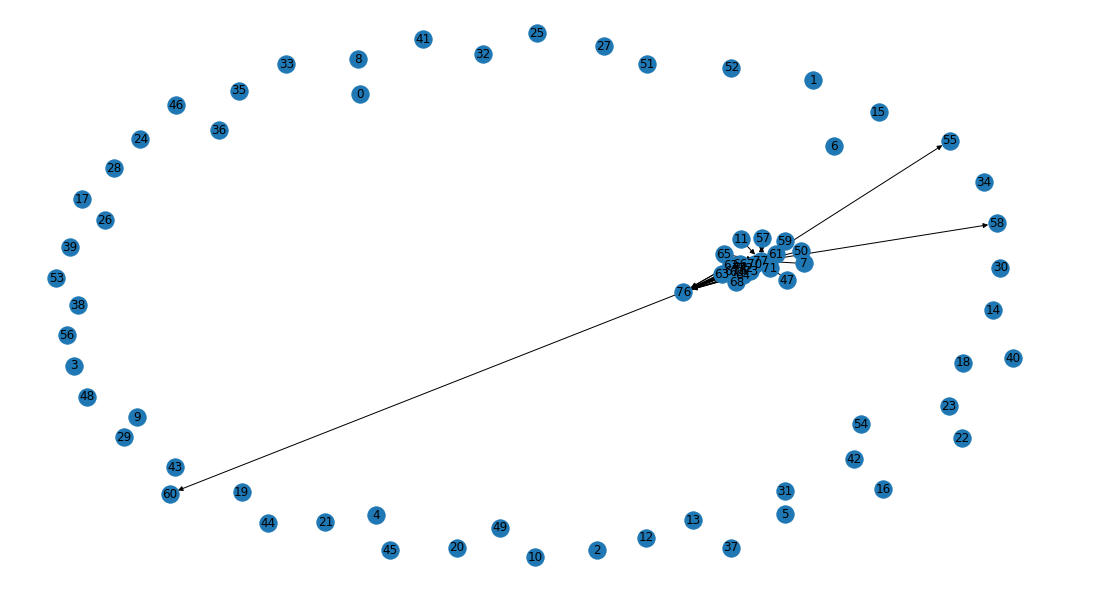

In [12]:
figure(figsize=(15,8))

nx.draw(D, with_labels=True)
plt.show()

In [13]:
#Poiche il dataset Communities ha, in ogni riga, gli autori separati dal carattere '*', 
#per rendere efficiente il calcolo in seguito, vengono splittati ora
Communities_splitted = pd.DataFrame(columns=['community','authors'])
Communities_splitted.community = range(0,len(Communities))
Communities_splitted.set_index('community',inplace = True)


#autori = Communities.loc[i]['cluster_authors'].split("*")
Communities_splitted['authors'] = Communities['cluster_authors'].apply(lambda row: row.split("*"))

    
Communities_splitted
    


,authors
community,
0,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
1,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
2,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
3,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
4,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
...,...
73,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
74,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
75,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...


In [14]:
#Nelle due celle seguenti viene mostrata la differenza tra i due DF

In [15]:
Communities.iloc[-1]['cluster_authors']

'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAzYWMcfx5jSTIH8D6G8mJ\nQPFkDQNFneySj5NnaRtyHeIBv4INmbW6upgnr7d1FUTlI7bKAq8zQeDqzNW0/eX7\nfFLovpWSqOmQBi5udYqyIyfK8eoONZBCM9B+gXzDX7nD0e27a5xfqMGAgKRE+lmL\nj6vf7Hf1uiD2OmonULKNuGbfCWD/XR8ERCbt/lDwm6K/EG9L1nbniK3PPl3qdq/Y\nXq7+d164dm3C6HZSz5CEslUbo0C1M8c5DrdtXJJW6NUGFh2G/6lXp8+O1yRzTVvy\ng5+AZrQhDhTR+1XZagl0kePvNBd9VSGm9evRodCWOM4fD81oMqvwHRhEDQZiWj6Q\nMQIDAQAB\n-----END PUBLIC KEY-----\n*-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAzMTu4ckscA29K63hfgc8\nGXGaxtprbsOO87xNW1L2OZvpXJkP11szgVRS8X7pJq/TCROnvEqpWVYTYnpZ7JLt\nBhDv7bRA2uZCS1/9yDmwSjaiK83/2DarUCN+BzE5reXeWhTArtx0TjMsUcEFBFXT\nxmOfFuX6qT8gW4SpH0OvSN78212Yup38RMMrL3w87m7Cbg4w40yDzU5vvv6n6Lsm\nHUiPBtRa9zAAnImyW7LeICpGAejF3/xRAWPzrpZRieW1S0judC8eYeE6pRPBGTS2\noo+W/3gmgp8CxOvnroxSfz8qcNJyDQq6vEG/XWugGOg6p0ZPtwVjHck4fK6ZyNv/\n7wIDAQAB\n-----END PUBLIC KEY-----\n*-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAyithp

In [16]:
Communities_splitted.iloc[-1]['authors']

['-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAzYWMcfx5jSTIH8D6G8mJ\nQPFkDQNFneySj5NnaRtyHeIBv4INmbW6upgnr7d1FUTlI7bKAq8zQeDqzNW0/eX7\nfFLovpWSqOmQBi5udYqyIyfK8eoONZBCM9B+gXzDX7nD0e27a5xfqMGAgKRE+lmL\nj6vf7Hf1uiD2OmonULKNuGbfCWD/XR8ERCbt/lDwm6K/EG9L1nbniK3PPl3qdq/Y\nXq7+d164dm3C6HZSz5CEslUbo0C1M8c5DrdtXJJW6NUGFh2G/6lXp8+O1yRzTVvy\ng5+AZrQhDhTR+1XZagl0kePvNBd9VSGm9evRodCWOM4fD81oMqvwHRhEDQZiWj6Q\nMQIDAQAB\n-----END PUBLIC KEY-----\n',
 '-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAzMTu4ckscA29K63hfgc8\nGXGaxtprbsOO87xNW1L2OZvpXJkP11szgVRS8X7pJq/TCROnvEqpWVYTYnpZ7JLt\nBhDv7bRA2uZCS1/9yDmwSjaiK83/2DarUCN+BzE5reXeWhTArtx0TjMsUcEFBFXT\nxmOfFuX6qT8gW4SpH0OvSN78212Yup38RMMrL3w87m7Cbg4w40yDzU5vvv6n6Lsm\nHUiPBtRa9zAAnImyW7LeICpGAejF3/xRAWPzrpZRieW1S0judC8eYeE6pRPBGTS2\noo+W/3gmgp8CxOvnroxSfz8qcNJyDQq6vEG/XWugGOg6p0ZPtwVjHck4fK6ZyNv/\n7wIDAQAB\n-----END PUBLIC KEY-----\n',
 '-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKC

a[PR(auth_i)/PR_Max] + b[#cit_entranti_i/#cit_entranti_Max] + c[AVG(PR_auth_citano_i)/PR_Max] + d[Communities value]

In [14]:
#TEST FATTO IGNORANDO I WEIGHT TRA LE COMMUNITIES, CONSIDERO SOLO I #HOP


#Definisco i valori comuni necessari al calcolo

#PR normalization---
PR_Max = PR_df.query('PR_values == PR_values.max()')['PR_values'].values[0]
PR_Min = PR_df.query('PR_values == PR_values.min()')['PR_values'].values[0]
PR_Difference = PR_Max - PR_Min
PR_mean = PR_df.PR_values.mean()
PR_stdev = PR_df.PR_values.std()
print(PR_Min)

#max_cit_entranti---
genesis_tx_node_id = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']=='Not_available']['ToNodeId'].values[0]
#RIMUOVO LE CITAZIONI INIZIALI FATTE VERSO LA GENESIS TX DAGLI ARTICOLI DI FRONTIERA
DB_AA_originale_senza_genesis = DB_AA_originale[DB_AA_originale['ToNodeId']!= genesis_tx_node_id]
res = DB_AA_originale_senza_genesis.groupby('To_Author_Pub_key')['From_Author_Pub_Key'].count()
cit_entranti_max = res.max()
cit_entranti_min = res.min()
cit_entranti_Difference = cit_entranti_max - cit_entranti_min
cit_entranti_mean = DB_AA_originale_senza_genesis.groupby('To_Author_Pub_key')['From_Author_Pub_Key'].count().mean()
cit_entranti_stdev =DB_AA_originale_senza_genesis.groupby('To_Author_Pub_key')['From_Author_Pub_Key'].count().std()
print(cit_entranti_min)

#max_len_#_hop---
path = dict(nx.all_pairs_dijkstra_path(D))
list_of_len = []
max_len = 0
min_len = len(D.nodes)
for node in D.nodes: #per ogni nodo
    for paths in path[node]: #per ogni nodo raggiungibile da tale nodo
        if(paths != node):
            local_len = len(path[node][paths])-1
            list_of_len.append(local_len)
            if(local_len > max_len):
                max_len = local_len
            elif(local_len < min_len):
                min_len = local_len

print(max_len)
print(min_len)
len_Difference = max_len - min_len
print(len_Difference)
mean_len = statistics.mean(list_of_len)
stdev_len = statistics.stdev(list_of_len)



0.0004834505536795
1
5
1
4


In [15]:
#Fornito in input un set di ids delle communities che citano un articolo & community autore articolo citato
#Per ogni community, calcola la distanza media tra di essa e tutte le altre.
#Poi viene restituita la distanza media minore.

#viene invocata solo se il numero di communities coinvolte è > 1 => l'articolo è citato da almeno una community diversa da quella del suo autore

def computeMinOfHopAvgDist(communities_coinvolte):
    
    min_avg_dist = max_len #init la distanza minore individuata finora al valore della distanza max
    
    #print(f'COMP, comm_coinvolte: {communities_coinvolte}')
    
    for i in communities_coinvolte: #per ogni community citante
        
        #print(f'I: {i}')
        
        local_avg_dist = 0

        for j in communities_coinvolte: #scandisco le altre communities citanti
            #print(f'J: {j}')
            if(i!=j):
                if(str(j) in path[str(i)]):
                    local_avg_dist += len(path[str(i)][str(j)])-1 #se esiste path tra loro, prendo il num di hop
                    #print(f'LAD1: {local_avg_dist}')
                else:
                    local_avg_dist += max_len #se non esiste path tra loro, assumo #hop massimo nel grafo PERCHE maggiore è la distanza e maggiore è il punteggio assegnato
                    #print(f'LAD2: {local_avg_dist}')
                    
        local_avg_dist = local_avg_dist/(len(communities_coinvolte)-1) #calcolo media distanza tra la community e le altre (che in numero sono len(communities_coinvolte)-1)
            
        #print(f'LAD3: {local_avg_dist}')
            
            
        if(local_avg_dist > 0 and local_avg_dist < min_avg_dist):
            min_avg_dist = local_avg_dist

    return min_avg_dist


In [16]:
#Fornito in input un set di ids delle communities che citano un articolo & community autore articolo citato
#Per ogni community, calcola la distanza media tra di essa e tutte le altre.
#Poi viene restituita la distanza media minore.

#viene invocata solo se il numero di communities coinvolte è > 1 => l'articolo è citato da almeno una community diversa da quella del suo autore

def computeAvgOfHopAvgDist(communities_coinvolte):
    

    avg_dist = 0 #init la distanza media
    
    #print(f'COMP, comm_coinvolte: {communities_coinvolte}')
    
    for i in communities_coinvolte: #per ogni community citante
        
        #print(f'I: {i}')
        
        local_avg_dist = 0

        for j in communities_coinvolte: #scandisco le altre communities citanti
            #print(f'J: {j}')
            if(i!=j):
                if(str(j) in path[str(i)]):
                    local_avg_dist += len(path[str(i)][str(j)])-1 #se esiste path tra loro, prendo il num di hop
                    #print(f'LAD1: {local_avg_dist}')
                else:
                    local_avg_dist += max_len #se non esiste path tra loro, assumo #hop massimo nel grafo PERCHE maggiore è la distanza e maggiore è il punteggio assegnato
                    #print(f'LAD2: {local_avg_dist}')
                    
        local_avg_dist = local_avg_dist/(len(communities_coinvolte)-1) #calcolo media distanza tra la community e le altre (che in numero sono len(communities_coinvolte)-1)
            
        #print(f'LAD3: {local_avg_dist}')
            
            
        avg_dist += local_avg_dist

    return avg_dist/len(communities_coinvolte)


In [18]:
#MIN MAX REGULARIZATION OF EACH VARIABLE
def computeEstimateMinMax(a,b,c,d):

    df_stima_analysis = pd.DataFrame(columns = ['article_id'], index = range(len(msg_DB)))

    df_stima_analysis['article_id'] = msg_DB

    df_stima_analysis['estimate'] = None

    df_stima_analysis['PR_author'] = None

    df_stima_analysis['PR_author'] = df_stima_analysis.apply(lambda row : PR_df[PR_df['Author'] == DB_AA_originale[DB_AA_originale['FromNodeId']==row['article_id']]['From_Author_Pub_Key'].values[0]]['PR_values'].values[0], axis = 1)

    ##

    df_stima_analysis['Num_cit_received'] = None

    df_stima_analysis['Num_cit_received'] = df_stima_analysis.apply(lambda row : len(DB_AA_originale[DB_AA_originale['ToNodeId']==row['article_id']]), axis = 1)

    ##

    df_stima_analysis['Avg_Pr_citing_authors'] = None

    df_stima_analysis['Avg_Pr_citing_authors'] = df_stima_analysis.apply(lambda row: PR_df[PR_df['Author'].isin(DB_AA_originale[DB_AA_originale['ToNodeId']==row['article_id']]['From_Author_Pub_Key'].values)]['PR_values'].mean(), axis = 1)

    ##

    df_stima_analysis['Min_of_avg_dist_among_communities'] = None

    Min_of_hop_avg_dist_list = []
    estimate_list  =  []

    
    #Min_of_hop_avg_dist = valore => articolo citato da almeno una community che non è la sua di appartenenza
    #Min_of_hop_avg_dist = 0 => articolo citato da nessuno
    #Min_of_hop_avg_dist = -1 => articolo citato solo dalla sua community di appartenenza
    

    for i in range(len(df_stima_analysis)):

            autore = DB_AA_originale[DB_AA_originale['FromNodeId']==df_stima_analysis.iloc[i]['article_id']]['From_Author_Pub_Key'].values[0]

            if(df_stima_analysis.iloc[i]['Num_cit_received'] > 0):

                autori_citanti = DB_AA_originale[DB_AA_originale['ToNodeId']==df_stima_analysis.iloc[i]['article_id']]['From_Author_Pub_Key'].values

                #print(autori_citanti)

                #calcolo la distanza tra le communities che mi citano 


                communities_coinvolte = []

                autori_coinvolti = autori_citanti 
                autori_coinvolti = np.append(autori_coinvolti,autore)

                #in questo modo insierisco anche la community dell'autore dell'articolo 
                #=> calcolo la distanza media tra tutte le communities coinvolte, quelle dell'autore citato e citante 

                for k in autori_coinvolti:
                    for j in range(len(Communities_splitted)):
                        if(k in Communities_splitted.loc[j]['authors'] ):
                            communities_coinvolte.append(j)

                communities_coinvolte = np.unique(communities_coinvolte) #rimuovo duplicati
                
                
                if(len(communities_coinvolte)==1):

                    estimate_list.append(a*((df_stima_analysis.iloc[i]['PR_author']-PR_Min)/PR_Difference) + b*((df_stima_analysis.iloc[i]['Num_cit_received']-cit_entranti_min)/cit_entranti_Difference) + c*((df_stima_analysis.iloc[i]['Avg_Pr_citing_authors']-PR_Min)/PR_Difference))
                    #stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_Min)/PR_Difference) + b*((num_cit_entranti-cit_entranti_min)/cit_entranti_Difference) + c*((AVG_PR_autori_citanti-PR_Min)/PR_Difference)  
                    Min_of_hop_avg_dist_list.append(-1)

                else:

                    Min_of_hop_avg_dist = computeMinOfHopAvgDist(communities_coinvolte)


                    Min_of_hop_avg_dist_list.append(Min_of_hop_avg_dist)


                    if(Min_of_hop_avg_dist<1):
                        print(Min_of_hop_avg_dist)

                    estimate_list.append(a*((df_stima_analysis.iloc[i]['PR_author']-PR_Min)/PR_Difference) + b*((df_stima_analysis.iloc[i]['Num_cit_received']-cit_entranti_min)/cit_entranti_Difference) + c*((df_stima_analysis.iloc[i]['Avg_Pr_citing_authors']-PR_Min)/PR_Difference) + d*((Min_of_hop_avg_dist-min_len)/len_Difference))
                    #stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_Min)/PR_Difference) + b*((num_cit_entranti-cit_entranti_min)/cit_entranti_Difference) + c*((AVG_PR_autori_citanti-PR_Min)/PR_Difference) + d*((Min_of_hop_avg_dist-min_len)/len_Difference)  

            else:

                Min_of_hop_avg_dist_list.append(0)

                estimate_list.append(a*((df_stima_analysis.iloc[i]['PR_author']-PR_Min)/PR_Difference))



    df_stima_analysis['estimate'] = estimate_list

    df_stima_analysis['Min_of_avg_dist_among_communities'] = Min_of_hop_avg_dist_list

    return df_stima_analysis

In [19]:
#STRONG SIMPLE DIVISION BY MAX VALUE
def computeEstimateDividingByMax(a,b,c,d):

    df_stima_analysis = pd.DataFrame(columns = ['article_id'], index = range(len(msg_DB)))

    df_stima_analysis['article_id'] = msg_DB

    df_stima_analysis['estimate'] = None

    df_stima_analysis['PR_author'] = None

    df_stima_analysis['PR_author'] = df_stima_analysis.apply(lambda row : PR_df[PR_df['Author'] == DB_AA_originale[DB_AA_originale['FromNodeId']==row['article_id']]['From_Author_Pub_Key'].values[0]]['PR_values'].values[0], axis = 1)

    ##

    df_stima_analysis['Num_cit_received'] = None

    df_stima_analysis['Num_cit_received'] = df_stima_analysis.apply(lambda row : len(DB_AA_originale[DB_AA_originale['ToNodeId']==row['article_id']]), axis = 1)

    ##

    df_stima_analysis['Avg_Pr_citing_authors'] = None

    df_stima_analysis['Avg_Pr_citing_authors'] = df_stima_analysis.apply(lambda row: PR_df[PR_df['Author'].isin(DB_AA_originale[DB_AA_originale['ToNodeId']==row['article_id']]['From_Author_Pub_Key'].values)]['PR_values'].mean(), axis = 1)

    ##

    df_stima_analysis['Min_of_avg_dist_among_communities'] = None

    Min_of_hop_avg_dist_list = []
    estimate_list  =  []

    #Min_of_hop_avg_dist = valore => articolo citato da almeno una community che non è la sua di appartenenza
    #Min_of_hop_avg_dist = 0 => articolo citato da nessuno
    #Min_of_hop_avg_dist = -1 => articolo citato solo dalla sua community di appartenenza

    for i in range(len(df_stima_analysis)):

            autore = DB_AA_originale[DB_AA_originale['FromNodeId']==df_stima_analysis.iloc[i]['article_id']]['From_Author_Pub_Key'].values[0]

            if(df_stima_analysis.iloc[i]['Num_cit_received'] > 0):

                autori_citanti = DB_AA_originale[DB_AA_originale['ToNodeId']==df_stima_analysis.iloc[i]['article_id']]['From_Author_Pub_Key'].values

                #print(autori_citanti)

                #calcolo la distanza tra le communities che mi citano 


                communities_coinvolte = []

                autori_coinvolti = autori_citanti 
                autori_coinvolti = np.append(autori_coinvolti,autore)

                #in questo modo insierisco anche la community dell'autore dell'articolo 
                #=> calcolo la distanza media tra tutte le communities coinvolte, quelle dell'autore citato e citante 

                for k in autori_coinvolti:
                    for j in range(len(Communities_splitted)):
                        if(k in Communities_splitted.loc[j]['authors'] ):
                            communities_coinvolte.append(j)

                communities_coinvolte = np.unique(communities_coinvolte) #rimuovo duplicati
                #len(communities_coinvolte)>=1, poiche contiene sempre la community dell'autore dell'articolo, piu quelle citanti

                #len(communities_coinvolte) = 1 quando la community che cita è la stessa dell'autore che ha scritto articolo

                #print(communities_coinvolte)

                if(len(communities_coinvolte)==1):

                    estimate_list.append(a*(df_stima_analysis.iloc[i]['PR_author']/PR_Max) + b*(df_stima_analysis.iloc[i]['Num_cit_received']/cit_entranti_max) + c*(df_stima_analysis.iloc[i]['Avg_Pr_citing_authors']/PR_Max) )
                    #stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_Min)/PR_Difference) + b*((num_cit_entranti-cit_entranti_min)/cit_entranti_Difference) + c*((AVG_PR_autori_citanti-PR_Min)/PR_Difference)  
                    Min_of_hop_avg_dist_list.append(-1)

                else:

                    Min_of_hop_avg_dist = computeMinOfHopAvgDist(communities_coinvolte)


                    Min_of_hop_avg_dist_list.append(Min_of_hop_avg_dist)


                    if(Min_of_hop_avg_dist<1):
                        print(Min_of_hop_avg_dist)

                    estimate_list.append(a*(df_stima_analysis.iloc[i]['PR_author']/PR_Max) + b*(df_stima_analysis.iloc[i]['Num_cit_received']/cit_entranti_max) + c*(df_stima_analysis.iloc[i]['Avg_Pr_citing_authors']/PR_Max) + d*(Min_of_hop_avg_dist/max_len) )
                    #stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_Min)/PR_Difference) + b*((num_cit_entranti-cit_entranti_min)/cit_entranti_Difference) + c*((AVG_PR_autori_citanti-PR_Min)/PR_Difference) + d*((Min_of_hop_avg_dist-min_len)/len_Difference)  

            else:

                Min_of_hop_avg_dist_list.append(0)

                estimate_list.append(a*(df_stima_analysis.iloc[i]['PR_author']/PR_Max))



    df_stima_analysis['estimate'] = estimate_list

    df_stima_analysis['Min_of_avg_dist_among_communities'] = Min_of_hop_avg_dist_list

    return df_stima_analysis

In [20]:
#MIN MAX DONE AFTER COMPUTATION
def computeEstimateMinMaxAfter(a,b,c,d):

    df_stima_analysis = pd.DataFrame(columns = ['article_id'], index = range(len(msg_DB)))

    df_stima_analysis['article_id'] = msg_DB

    df_stima_analysis['estimate'] = None

    df_stima_analysis['PR_author'] = None

    df_stima_analysis['PR_author'] = df_stima_analysis.apply(lambda row : PR_df[PR_df['Author'] == DB_AA_originale[DB_AA_originale['FromNodeId']==row['article_id']]['From_Author_Pub_Key'].values[0]]['PR_values'].values[0], axis = 1)

    ##

    df_stima_analysis['Num_cit_received'] = None

    df_stima_analysis['Num_cit_received'] = df_stima_analysis.apply(lambda row : len(DB_AA_originale[DB_AA_originale['ToNodeId']==row['article_id']]), axis = 1)

    ##

    df_stima_analysis['Avg_Pr_citing_authors'] = None

    df_stima_analysis['Avg_Pr_citing_authors'] = df_stima_analysis.apply(lambda row: PR_df[PR_df['Author'].isin(DB_AA_originale[DB_AA_originale['ToNodeId']==row['article_id']]['From_Author_Pub_Key'].values)]['PR_values'].mean(), axis = 1)

    ##

    df_stima_analysis['Min_of_avg_dist_among_communities'] = None

    Min_of_hop_avg_dist_list = []
    estimate_list  =  []


    #Min_of_hop_avg_dist = valore => articolo citato da almeno una community che non è la sua di appartenenza
    #Min_of_hop_avg_dist = 0 => articolo citato da nessuno
    #Min_of_hop_avg_dist = -1 => articolo citato solo dalla sua community di appartenenza
    
    
    for i in range(len(df_stima_analysis)):

            autore = DB_AA_originale[DB_AA_originale['FromNodeId']==df_stima_analysis.iloc[i]['article_id']]['From_Author_Pub_Key'].values[0]

            if(df_stima_analysis.iloc[i]['Num_cit_received'] > 0):

                autori_citanti = DB_AA_originale[DB_AA_originale['ToNodeId']==df_stima_analysis.iloc[i]['article_id']]['From_Author_Pub_Key'].values

                #print(autori_citanti)

                #calcolo la distanza tra le communities che mi citano 


                communities_coinvolte = []

                autori_coinvolti = autori_citanti 
                autori_coinvolti = np.append(autori_coinvolti,autore)

                #in questo modo insierisco anche la community dell'autore dell'articolo 
                #=> calcolo la distanza media tra tutte le communities coinvolte, quelle dell'autore citato e citante 

                for k in autori_coinvolti:
                    for j in range(len(Communities_splitted)):
                        if(k in Communities_splitted.loc[j]['authors'] ):
                            communities_coinvolte.append(j)

                communities_coinvolte = np.unique(communities_coinvolte) #rimuovo duplicati
                #len(communities_coinvolte)>=1, poiche contiene sempre la community dell'autore dell'articolo, piu quelle citanti

                #len(communities_coinvolte) = 1 quando la community che cita è la stessa dell'autore che ha scritto articolo

                #print(communities_coinvolte)

                if(len(communities_coinvolte)==1):

                    estimate_list.append(a*(df_stima_analysis.iloc[i]['PR_author']) + b*(df_stima_analysis.iloc[i]['Num_cit_received']) + c*(df_stima_analysis.iloc[i]['Avg_Pr_citing_authors']) )
                    #stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_Min)/PR_Difference) + b*((num_cit_entranti-cit_entranti_min)/cit_entranti_Difference) + c*((AVG_PR_autori_citanti-PR_Min)/PR_Difference)  
                    Min_of_hop_avg_dist_list.append(-1)

                else:

                    Min_of_hop_avg_dist = computeMinOfHopAvgDist(communities_coinvolte)


                    Min_of_hop_avg_dist_list.append(Min_of_hop_avg_dist)


                    if(Min_of_hop_avg_dist<1):
                        print(Min_of_hop_avg_dist)

                    estimate_list.append(a*(df_stima_analysis.iloc[i]['PR_author']) + b*(df_stima_analysis.iloc[i]['Num_cit_received']) + c*(df_stima_analysis.iloc[i]['Avg_Pr_citing_authors']) + d*(Min_of_hop_avg_dist) )
                    #stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_Min)/PR_Difference) + b*((num_cit_entranti-cit_entranti_min)/cit_entranti_Difference) + c*((AVG_PR_autori_citanti-PR_Min)/PR_Difference) + d*((Min_of_hop_avg_dist-min_len)/len_Difference)  

            else:

                Min_of_hop_avg_dist_list.append(0)

                estimate_list.append(a*(df_stima_analysis.iloc[i]['PR_author']))



    df_stima_analysis['estimate'] = estimate_list

    df_stima_analysis['Min_of_avg_dist_among_communities'] = Min_of_hop_avg_dist_list
    
    
    min_val = df_stima_analysis.estimate.min()
    max_val = df_stima_analysis.estimate.max()
    max_minus_min = max_val - min_val

    df_stima_analysis['estimate'] = df_stima_analysis['estimate'].apply(lambda row: (row - min_val)/max_minus_min)


    return df_stima_analysis

-DIVISION BY MAX IS TOO STRONG, DUE TO OUTLIER PRESENCE

-MIN MAX AFTER WHOLE COMPUTATION ALWAYS GIVES VALUES EQUAL TO 0 AND 1 AT THE EXTREMES

-MIN MAX IN THE WHILE IS SMOOTHER AND ENSURE ONLY 0 AT ONE EXTREME BUT NOT 1

# First test: compare the different methods of normalization

In [23]:


a = 0.25
b = 0.25
c = 0.25
d = 0.25

First_comparison = []

NORMALIZZAZIONE FATTA DIVIDENDO PER MAX_VALUE

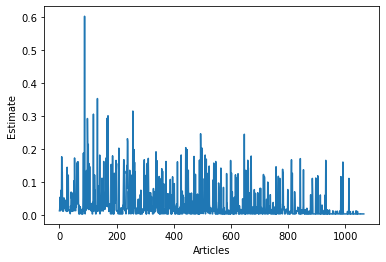

In [24]:
result = computeEstimateDividingByMax(a,b,c,d)
plt.xlabel('Articles')
plt.ylabel('Estimate')
result.estimate.plot()

First_comparison.append(result)

NORMALIZZAZIONE FATTA CON MINMAX DOPO IL CALCOLO COMPLETO

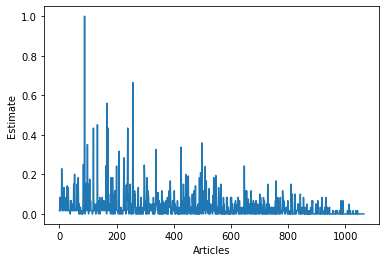

In [25]:
result = computeEstimateMinMaxAfter(a,b,c,d)
plt.xlabel('Articles')
plt.ylabel('Estimate')
result.estimate.plot()

First_comparison.append(result)

NORMALIZZAZIONE FATTA CON MIN MAX SU OGNI VARIABILE IN BASE ALLA SUA DISTRIBUZIONE

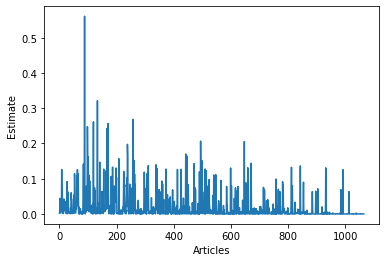

In [26]:
result = computeEstimateMinMax(a,b,c,d)
plt.xlabel('Articles')
plt.ylabel('Estimate')
result.estimate.plot()

First_comparison.append(result)

PRINT THE COMPARISON AMONG THE MAX OF ESTIMATE DONE BY THE THREE METHODS

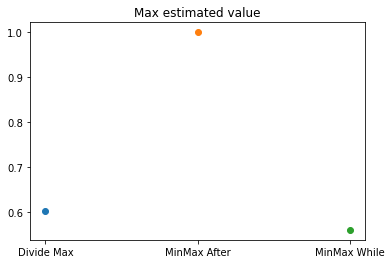

In [27]:
    
plt.scatter('Divide Max', First_comparison[0].estimate.max())
plt.scatter('MinMax After', First_comparison[1].estimate.max())
plt.scatter('MinMax While', First_comparison[2].estimate.max())


plt.rc('ytick', labelsize=20)
plt.title('Max estimated value')
plt.show()


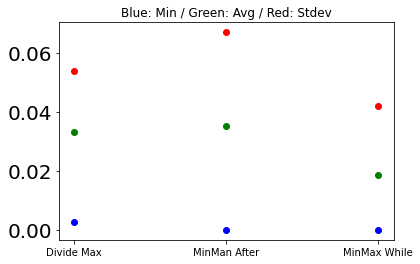

In [28]:
methods = ['Divide Max', 'MinMan After', 'MinMax While']

for v in range(len(First_comparison)):

    
    df = First_comparison[v]
    
    plt.scatter(methods[v], df.estimate.min(), label = 'min', color='blue')
    plt.scatter(methods[v], df.estimate.mean(), label = 'avg', color='green')
    plt.scatter(methods[v], df.estimate.std(), label = 'stdev', color='red')
    

plt.rc('ytick', labelsize=20)
#plt.legend()
plt.title('Blue: Min / Green: Avg / Red: Stdev')
plt.show()


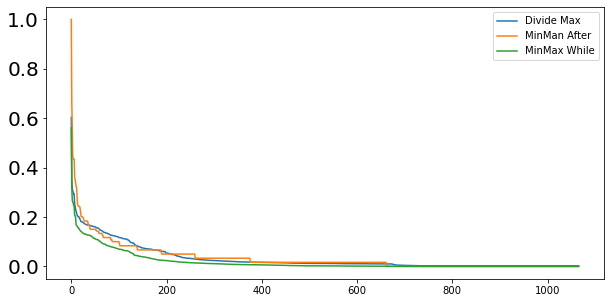

In [29]:
plt.figure(figsize=(10,5))

for i in range(len(First_comparison)):
    df = First_comparison[i]
    df.sort_values(by='estimate',ascending = False, inplace = True)
    df.reset_index(drop = True, inplace = True)
    df.estimate.plot(label=methods[i])
    
plt.legend()
plt.show()

IO SCEGLIEREI IL MINMAX-WHILE PERCHE PERMETTE LA NORMALIZZAZIONE DEI DATI, NON RESTITUISCE NECESSARIAMENTE ALMENO UN ARTICOLO CON STIMA = 1 (COSA CHE MINMAX-AFTER FA), IL MASSIMO VALORE GENERATO E' IL MINORE TRA I METODI => PAGA POCO => MAGGIOR DIFFICOLTA' DI CRESCITA PER AUTORI

# TEST VARIANDO A,B,C,D SULLA SOLUZIONE 3 (MIN MAX SU OGNI VARIABILE)

Io voglio un sistema di punteggio tale che: 
* non permetta di avere coefficienti alti che possono far boostare la stima semplicemente aumentando il parametro del coefficiente. Se faccio spam aumentano citazioni ricevute e PR, di conseguenza non posso dare coefficienti troppo alti in a & b.

* dia priorità all'autorevolezza di chi mi cita e al numero di diverse bolle che influenzo

* una power law descriva l'andamento della formula (da un fenomeno di vita reale mi aspetto questo)

# io direi di scegliere la 13/14 perche:
* mediamente produce valori piccoli (max = 0.32) => maggior difficoltà per avere notorietà e possibilità di ospitare grandi fenomeni virali e rimanere comunqnue con punteggi che non crescono troppo

* non si hanno comportamenti in cui l'articolo più citato svetta su tutti gli altri (cosa che accade nei test da 0 a 6) => resistenza allo spam, non basta una spammata per portare in alto un articolo

* i test da 0 a 6 sono troppo basati sul numero di citazioni e sul page rank dell'autore (che a sua volta dipende dal numero di citazioni ricevute), mentre vogliamo dare peso all'autorevolezza di chi cita e al numero di diverse communities influenzate

* quando ci sono coefficienti troppo alti è più semplice fregare il punteggio e posizionarsi in alto, basta soddisfare un minimo il valore associato al coefficiente alto => i coefficienti alti devono essere quelli associati alle variabili più difficili da far crescere (che noi vogliamo crescano). Queste sono le ultime due. Infatti essendo difficili da masterare, si ottengono risultati bassi in media e max value.

# interessante notare come esistono articoli che hanno poche citazioni (1, 2,3,4) e nonostante questo sono in ottima posizione per la stima di veridicità. Questo accade quando il page rank dell'autore è molto alto O quando sono citati da un autore con page rank alto.  

# Test the different values of a,b,c,d 

V: 0
V: 1
V: 2
V: 3
V: 4
V: 5
V: 6
V: 7
V: 8
V: 9
V: 10
V: 11
V: 12
V: 13
V: 14


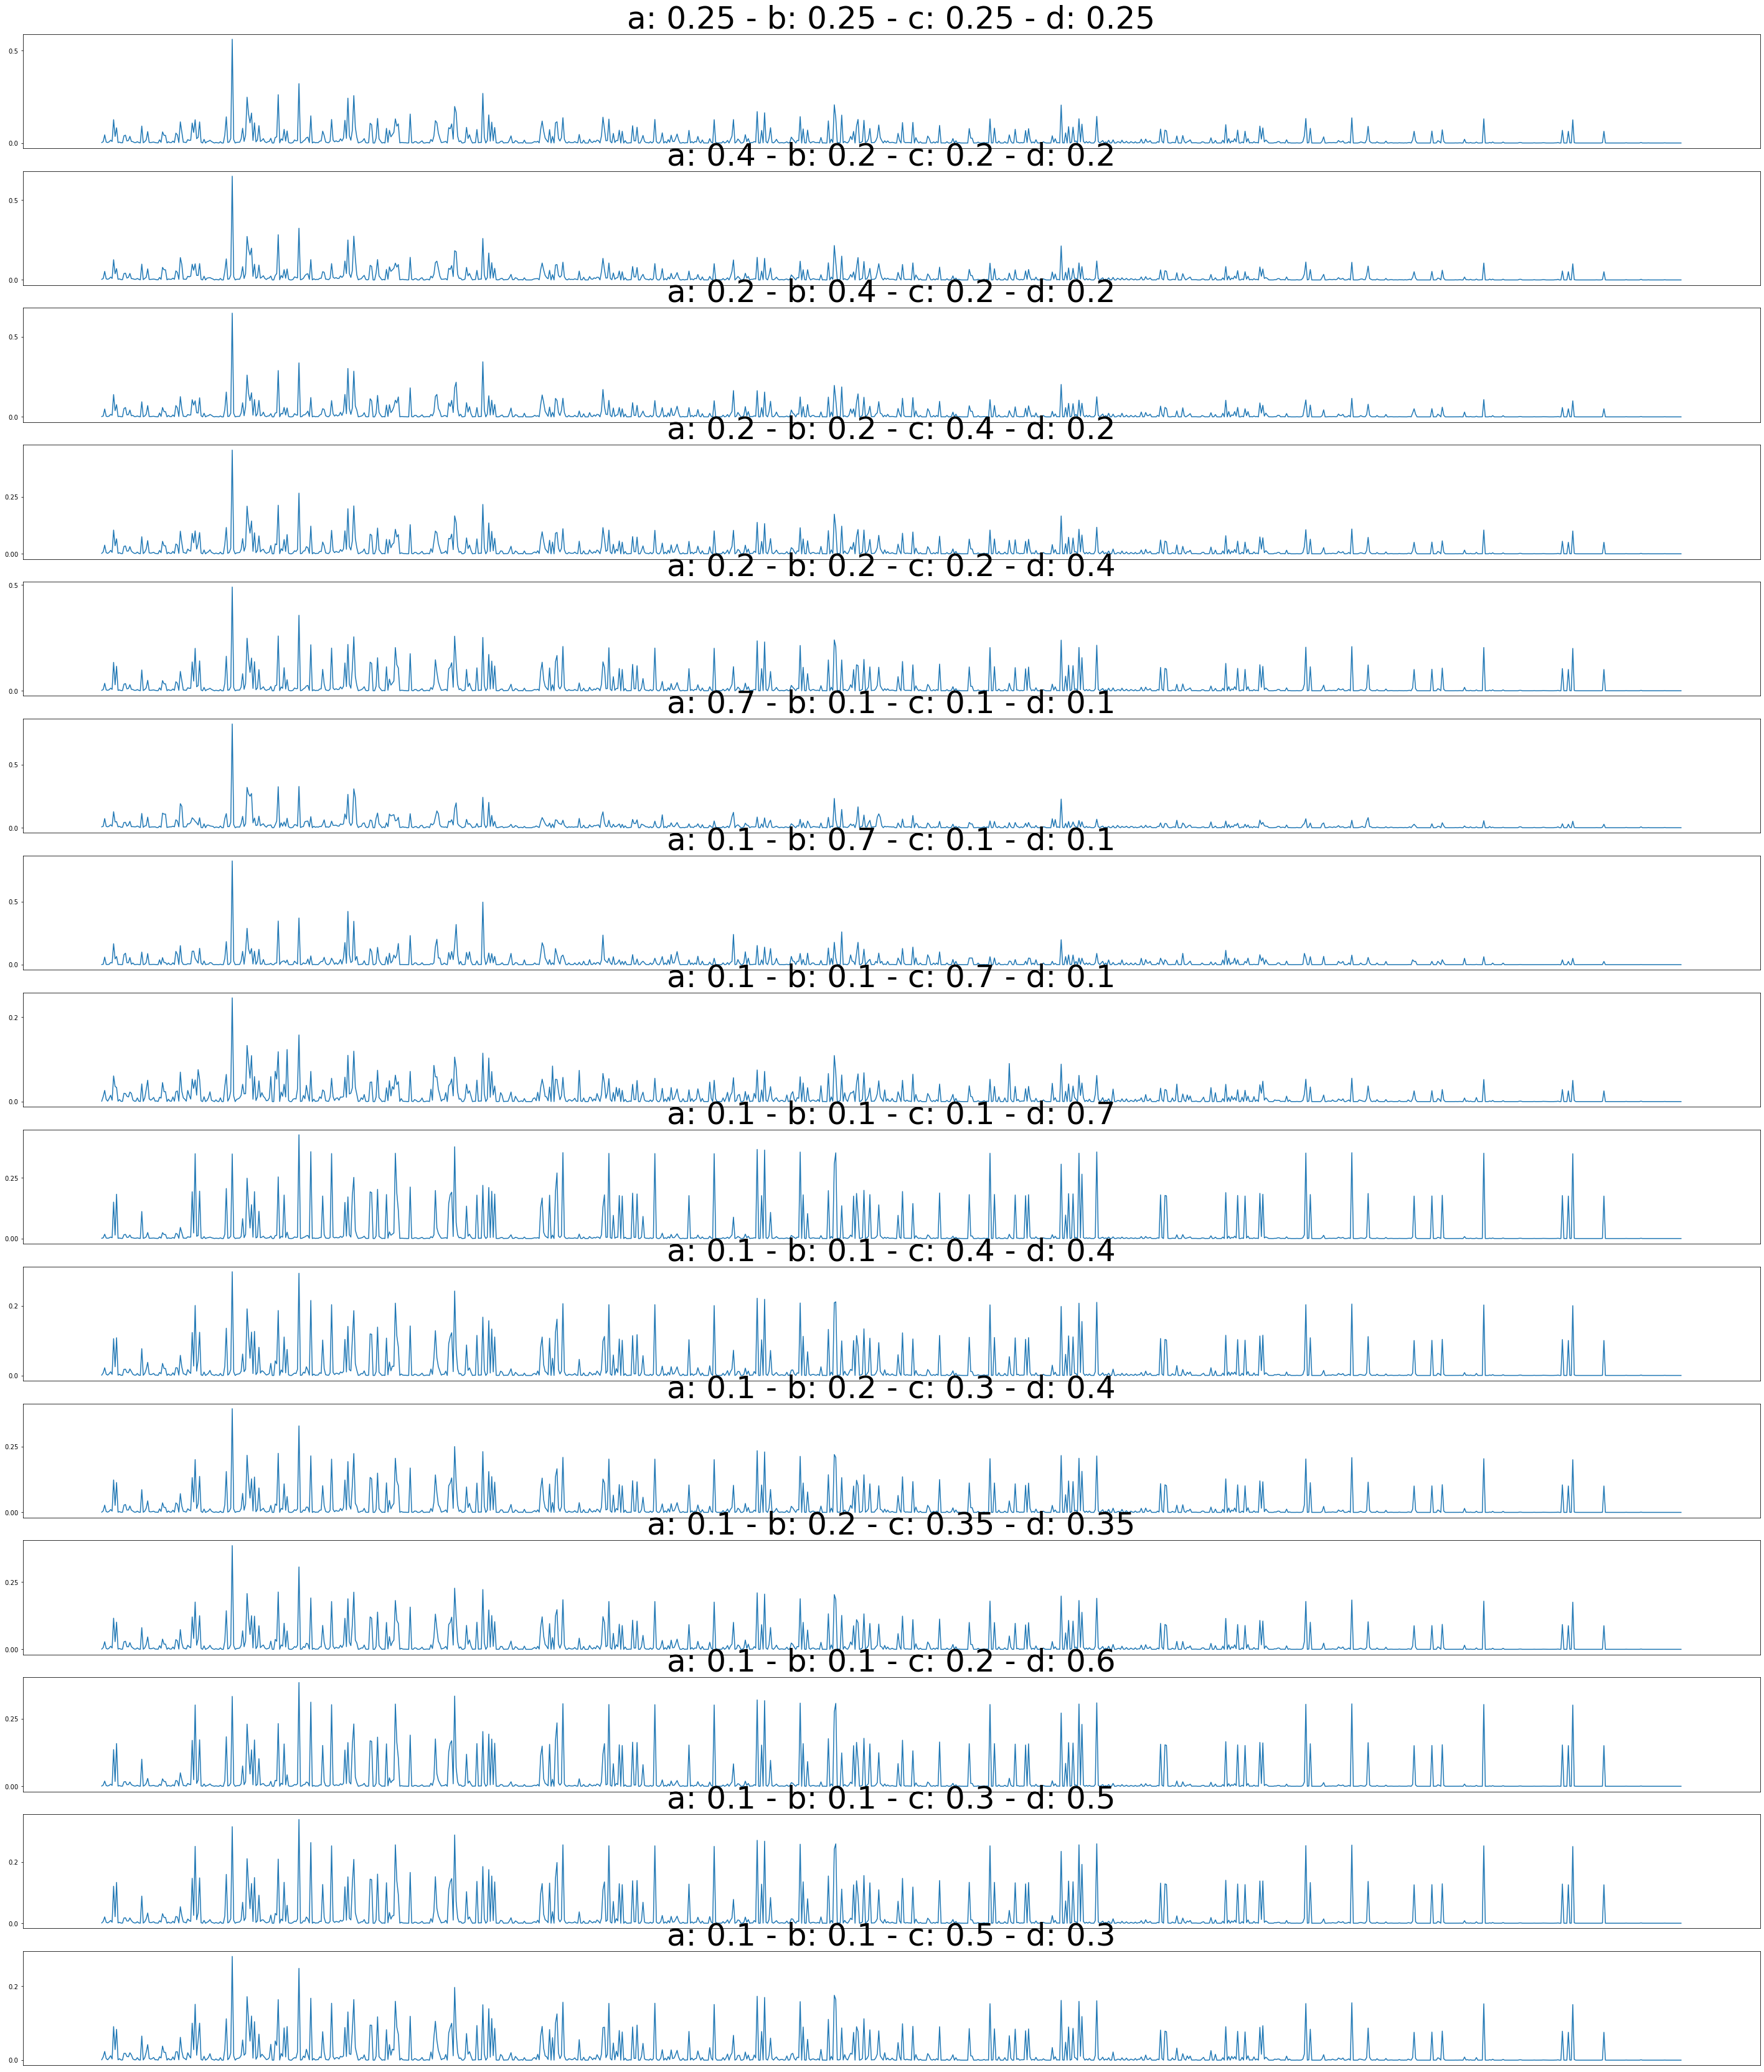

In [22]:
Second_Comparison = []


figure, axis = plt.subplots(15,1,figsize=(50, 60))


Variabili = [(0.25,0.25,0.25,0.25), (0.4,0.2,0.2,0.2), (0.2,0.4,0.2,0.2), (0.2,0.2,0.4,0.2), (0.2,0.2,0.2,0.4), 
            (0.7,0.1,0.1,0.1), (0.1,0.7,0.1,0.1), (0.1,0.1,0.7,0.1), (0.1,0.1,0.1,0.7), (0.1,0.1,0.4,0.4),
             (0.1,0.2,0.3,0.4),(0.1,0.2,0.35,0.35),(0.1,0.1,0.2,0.6),(0.1,0.1,0.3,0.5),(0.1,0.1,0.5,0.3)]

for v in range(len(Variabili)):
    print(f'V: {v}')
    valori = Variabili[v]
    
    a = valori[0]
    b = valori[1]
    c = valori[2]
    d = valori[3]

    Second_Comparison.append(computeEstimateMinMax(a,b,c,d))
    
    
    title = 'a: '+str(a)+' - '+'b: '+str(b)+' - '+'c: '+str(c)+' - '+'d: '+str(d)
    axis[v].plot(Second_Comparison[v].estimate)
    axis[v].set_title(title,fontsize = 50)
    axis[v].get_xaxis().set_visible(False)

plt.rc('ytick', labelsize=40)
plt.show()

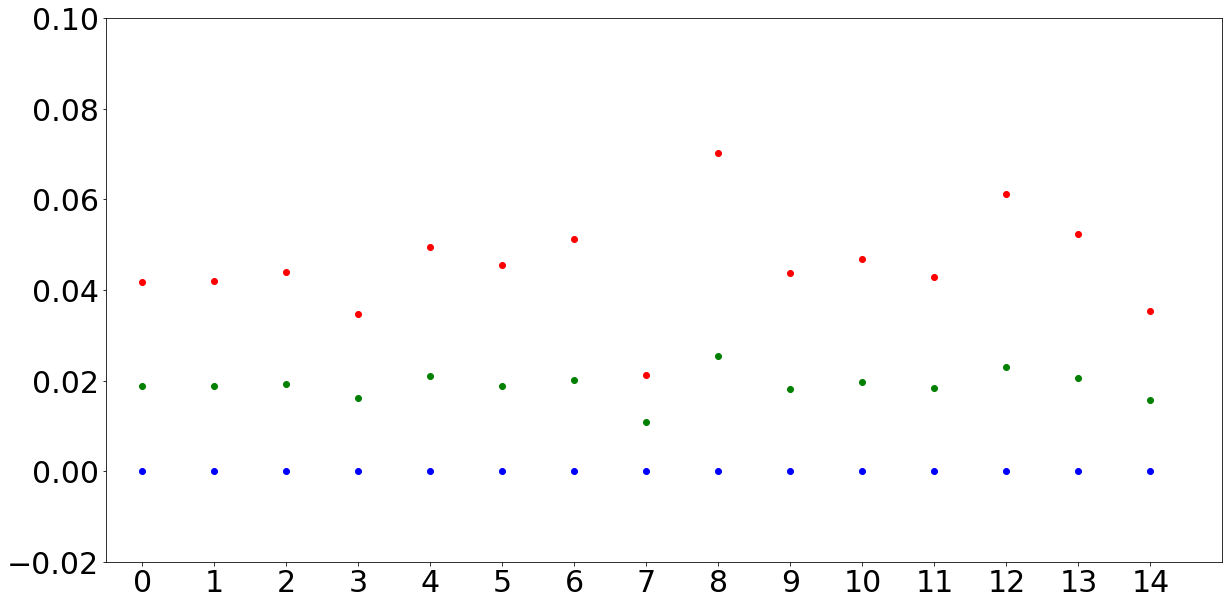

Valori: 0 
a: 0.25, b: 0.25, c: 0.25, d: 0.25
Valori: 1 
a: 0.4, b: 0.2, c: 0.2, d: 0.2
Valori: 2 
a: 0.2, b: 0.4, c: 0.2, d: 0.2
Valori: 3 
a: 0.2, b: 0.2, c: 0.4, d: 0.2
Valori: 4 
a: 0.2, b: 0.2, c: 0.2, d: 0.4
Valori: 5 
a: 0.7, b: 0.1, c: 0.1, d: 0.1
Valori: 6 
a: 0.1, b: 0.7, c: 0.1, d: 0.1
Valori: 7 
a: 0.1, b: 0.1, c: 0.7, d: 0.1
Valori: 8 
a: 0.1, b: 0.1, c: 0.1, d: 0.7
Valori: 9 
a: 0.1, b: 0.1, c: 0.4, d: 0.4
Valori: 10 
a: 0.1, b: 0.2, c: 0.3, d: 0.4
Valori: 11 
a: 0.1, b: 0.2, c: 0.35, d: 0.35
Valori: 12 
a: 0.1, b: 0.1, c: 0.2, d: 0.6
Valori: 13 
a: 0.1, b: 0.1, c: 0.3, d: 0.5
Valori: 14 
a: 0.1, b: 0.1, c: 0.5, d: 0.3


In [29]:
Variabili = [(0.25,0.25,0.25,0.25), (0.4,0.2,0.2,0.2), (0.2,0.4,0.2,0.2), (0.2,0.2,0.4,0.2), (0.2,0.2,0.2,0.4), 
            (0.7,0.1,0.1,0.1), (0.1,0.7,0.1,0.1), (0.1,0.1,0.7,0.1), (0.1,0.1,0.1,0.7), (0.1,0.1,0.4,0.4), (0.1,0.2,0.3,0.4),
             (0.1,0.2,0.35,0.35),(0.1,0.1,0.2,0.6),(0.1,0.1,0.3,0.5),(0.1,0.1,0.5,0.3)]

plt.figure(figsize=(20,10))

for v in range(len(Variabili)):
    
    valori = Variabili[v]
    
    a = valori[0]
    b = valori[1]
    c = valori[2]
    d = valori[3]
    
    df = Second_Comparison[v]
    
    plt.scatter(v, df.estimate.max(), label = str(v), color='black')
    plt.scatter(v, df.estimate.min(), label = str(v), color='blue')
    plt.scatter(v, df.estimate.mean(), label = str(v), color='green')
    plt.scatter(v, df.estimate.std(), label = str(v), color='red')
    
    
    #axis[v].boxplot(stima_veridicita_articoli.estimate)
    #axis[v].set_title(title,fontsize = 50)
    #axis[v].get_xaxis().set_visible(False)
#plt.legend()

    #plt.rc('ytick', labelsize=40)
plt.rc('ytick', labelsize=30)
plt.axis([-0.5, 15, -0.02, 0.1])
#plt.title('CO')
plt.xticks(range(15))
plt.rc('xtick', labelsize=30)
plt.show()



for v in range(len(Variabili)):
    
    valori = Variabili[v]
    
    a = valori[0]
    b = valori[1]
    c = valori[2]
    d = valori[3]
    
    df = Second_Comparison[v]
    
    print(f'Valori: {v} ')
    print(f'a: {a}, b: {b}, c: {c}, d: {d}')

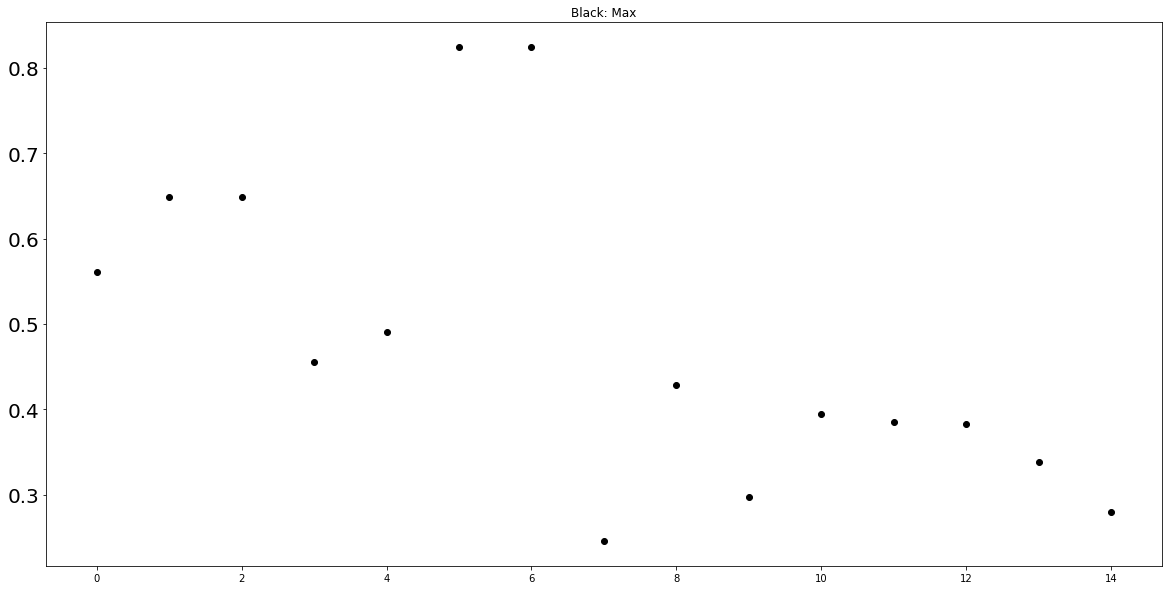

In [32]:
plt.figure(figsize=(20,10))

for v in range(len(Variabili)):
    
    valori = Variabili[v]
    
    a = valori[0]
    b = valori[1]
    c = valori[2]
    d = valori[3]
    
    df = Second_Comparison[v]
    
    plt.scatter(v, df.estimate.max(), label = str(v), color='black')
    
    #axis[v].boxplot(stima_veridicita_articoli.estimate)
    #axis[v].set_title(title,fontsize = 50)
    #axis[v].get_xaxis().set_visible(False)
#plt.legend()

    #plt.rc('ytick', labelsize=40)
plt.rc('ytick', labelsize=20)
#plt.axis([-0.5, 15, -0.02, 0.1])
plt.title('Black: Max')
plt.show()

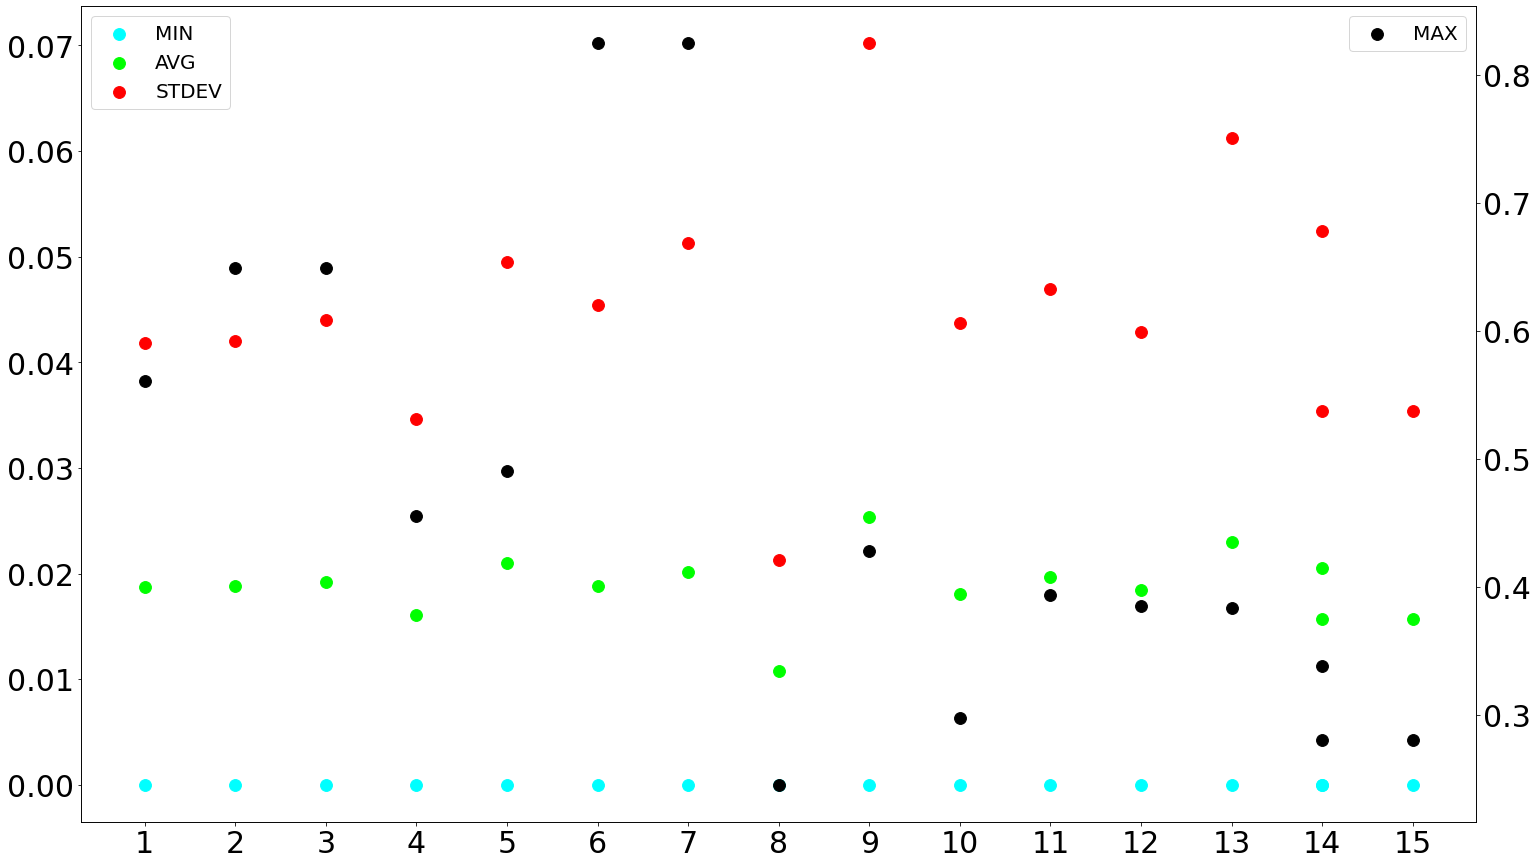

Valori: 0 
a: 0.25, b: 0.25, c: 0.25, d: 0.25
Valori: 1 
a: 0.4, b: 0.2, c: 0.2, d: 0.2
Valori: 2 
a: 0.2, b: 0.4, c: 0.2, d: 0.2
Valori: 3 
a: 0.2, b: 0.2, c: 0.4, d: 0.2
Valori: 4 
a: 0.2, b: 0.2, c: 0.2, d: 0.4
Valori: 5 
a: 0.7, b: 0.1, c: 0.1, d: 0.1
Valori: 6 
a: 0.1, b: 0.7, c: 0.1, d: 0.1
Valori: 7 
a: 0.1, b: 0.1, c: 0.7, d: 0.1
Valori: 8 
a: 0.1, b: 0.1, c: 0.1, d: 0.7
Valori: 9 
a: 0.1, b: 0.1, c: 0.4, d: 0.4
Valori: 10 
a: 0.1, b: 0.2, c: 0.3, d: 0.4
Valori: 11 
a: 0.1, b: 0.2, c: 0.35, d: 0.35
Valori: 12 
a: 0.1, b: 0.1, c: 0.2, d: 0.6
Valori: 13 
a: 0.1, b: 0.1, c: 0.3, d: 0.5
Valori: 14 
a: 0.1, b: 0.1, c: 0.5, d: 0.3


In [76]:
Variabili = [(0.25,0.25,0.25,0.25), (0.4,0.2,0.2,0.2), (0.2,0.4,0.2,0.2), (0.2,0.2,0.4,0.2), (0.2,0.2,0.2,0.4), 
            (0.7,0.1,0.1,0.1), (0.1,0.7,0.1,0.1), (0.1,0.1,0.7,0.1), (0.1,0.1,0.1,0.7), (0.1,0.1,0.4,0.4), (0.1,0.2,0.3,0.4),
             (0.1,0.2,0.35,0.35),(0.1,0.1,0.2,0.6),(0.1,0.1,0.3,0.5),(0.1,0.1,0.5,0.3)]

fig,ax = plt.subplots()


fig.set_figwidth(25)
fig.set_figheight(15)

for v in range(len(Variabili)):
    
    valori = Variabili[v]
    
    a = valori[0]
    b = valori[1]
    c = valori[2]
    d = valori[3]
    
    df = Second_Comparison[v]
    
    ax.scatter(v+1, df.estimate.min(),  color='cyan', s = 140)
    ax.scatter(v+1, df.estimate.mean(),  color='lime', s = 140)
    ax.scatter(v+1, df.estimate.std(),  color='red', s = 140)
    
df = Second_Comparison[-1]
    
ax.scatter(v, df.estimate.min(), label='MIN', color='cyan', s = 140)
ax.scatter(v, df.estimate.mean(),  label='AVG', color='lime', s = 140)
ax.scatter(v, df.estimate.std(),  label = 'STDEV', color='red', s = 140)
    

    
ax2=ax.twinx()


for v in range(len(Variabili)):
    
    valori = Variabili[v]
    
    a = valori[0]
    b = valori[1]
    c = valori[2]
    d = valori[3]
    
    df = Second_Comparison[v]
    
    ax2.scatter(v+1, df.estimate.max(), color='black', s = 140)

    
df = Second_Comparison[-1]
    
ax2.scatter(v, df.estimate.max(), label = 'MAX', color='black', s = 140)
    
ax.legend(prop = { "size": 20}, loc ="upper left")
ax2.legend(prop = { "size": 20 }, loc='upper right')


plt.xticks(range(1,16))
plt.show()



for v in range(len(Variabili)):
    
    valori = Variabili[v]
    
    a = valori[0]
    b = valori[1]
    c = valori[2]
    d = valori[3]
    
    df = Second_Comparison[v]
    
    print(f'Valori: {v} ')
    print(f'a: {a}, b: {b}, c: {c}, d: {d}')

In [36]:
df = Second_Comparison[14]
df.sort_values(by='estimate', inplace = True, ascending = False)
df.reset_index(drop = True, inplace = True)
df.iloc[:20]

,article_id,estimate,PR_author,Num_cit_received,Avg_Pr_citing_authors,Min_of_avg_dist_among_communities
0,8eaa59e9897f46763904a645649d1d1161a75f5ba10fba...,0.280256,0.042414,58,0.001972,1.833333
1,a0f0d9e63c5bc5a1963933c150a4fd11f82364698ae132...,0.248009,0.014411,24,0.002533,3.000000
2,43e5d6ce12c2273a2c87bdb139787e57158c9244f90def...,0.196553,0.005642,8,0.002326,3.000000
3,997ce5bc9f4bc168547d224dc55549c264d294bf3d0673...,0.175258,0.010959,10,0.002327,2.500000
4,5e6a8e89d708f255ba14deaa6c1cd0cd189be0d342ccae...,0.172602,0.001656,9,0.000967,3.000000
5,3b26e4c23f04f784fa6fdefb74d697e282f5555002719f...,0.171634,0.015953,19,0.002845,2.000000
6,7ddc964dce84cf81a02dab5bcdecbf690045e5091446e9...,0.169478,0.001366,8,0.000911,3.000000
7,b18f88eebd4bcec13dbff92b1de51f6a81c14281e487c8...,0.167259,0.002527,2,0.001375,3.000000
8,ddbc949d3120f0773a2c7b8c03d7b3365a8002edc426e9...,0.163743,0.014887,24,0.001661,2.000000
9,6b624fe4f568076927bafaa8b3d27d74e15e5c0da76c74...,0.163550,0.015953,24,0.001432,2.000000


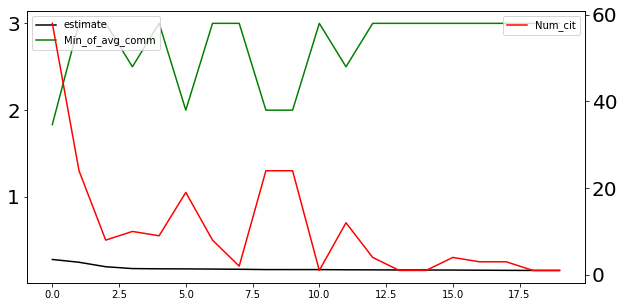

In [37]:
fig,ax = plt.subplots()


fig.set_figwidth(10)
fig.set_figheight(5)

ax.plot(df.index.values[:20], df.estimate.values[:20], label = "estimate", color ='black')
ax.plot(df.index.values[:20], df.Min_of_avg_dist_among_communities.values[:20], label = "Min_of_avg_comm", color = 'green')



ax2=ax.twinx()
ax2.plot(df.index.values[:20], df.Num_cit_received.values[:20], label = "Num_cit", color = 'red')



ax.legend(prop = { "size": 10 }, loc ="upper left")
ax2.legend(prop = { "size": 10 }, loc ="upper right")
plt.show()

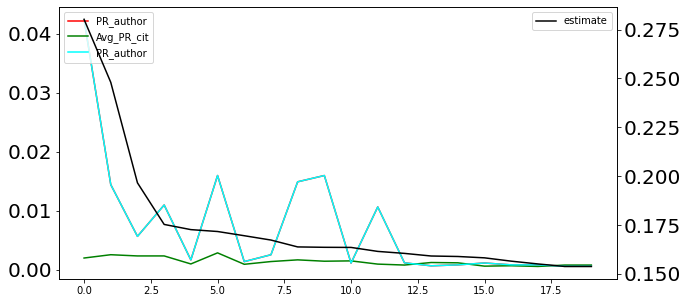

In [39]:
fig,ax = plt.subplots()


fig.set_figwidth(10)
fig.set_figheight(5)


#plt.axis([-1, 22, 0, 0.1])
ax.plot(df.index.values[:20], df.PR_author.values[:20], label = "PR_author", color = 'red')
ax.plot(df.index.values[:20], df.Avg_Pr_citing_authors.values[:20], label = "Avg_PR_cit", color = 'green')
ax.plot(df.index.values[:20], df.PR_author.values[:20], label = "PR_author", color = 'cyan')


ax2=ax.twinx()
ax2.plot(df.index.values[:20], df.estimate.values[:20], label = "estimate", color ='black')


ax.legend(prop = { "size": 10 }, loc ="upper left")

ax2.legend(prop = { "size": 10 }, loc ="upper right")
plt.show()